In [690]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns

In [691]:
# load the dataset
file_name = 'Activities.csv'
df = pd.read_csv(file_name)

# display all rows and columns when printing
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)

In [692]:
# display the first 5 rows to quickly inspect the dataset structure and values
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Speed,Max Speed,Total Ascent,Total Descent,Avg Stride Length,Steps,Min Temp,Best Lap Time,Max Temp,Avg Resp,Min Resp,Max Resp,Moving Time,Elapsed Time,Min Elevation,Max Elevation
0,Strength Training,2023-07-16 08:33:30,Strength,0.00,99,00:39:16,69,100,0.1,--,--,--,--,--,8,32.0,00:39:16,33.0,--,--,--,00:39:16,00:39:16,--,--
1,Strength Training,2023-06-30 15:06:33,Strength,0.00,99,00:39:35,69,102,0.1,--,--,--,--,--,12,31.0,00:39:35,33.0,--,--,--,00:39:35,00:39:35,--,--
2,Yoga,2024-03-22 08:12:44,Yoga,--,99,00:20:51,90,105,0.2,--,--,--,--,--,--,30.0,00:20:51,31.0,15,11,17,00:20:51,00:20:51,--,--
3,Yoga,2023-04-12 21:39:00,Yoga,--,99,00:46:20,69,98,0.0,--,--,--,--,--,44,27.0,00:46:20,31.0,19,12,22,00:46:20,00:46:20,--,--
4,Yoga,2022-11-16 21:49:35,Yoga,--,99,00:40:25,70,92,0.1,--,--,--,--,--,--,29.0,00:40:25,31.0,16,12,20,00:40:25,00:40:25,--,--


In [693]:
# display basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Activity Type      1978 non-null   object
 1   Date               1978 non-null   object
 2   Title              1978 non-null   object
 3   Distance           1978 non-null   object
 4   Calories           1978 non-null   object
 5   Time               1978 non-null   object
 6   Avg HR             1978 non-null   object
 7   Max HR             1978 non-null   object
 8   Aerobic TE         1978 non-null   object
 9   Avg Speed          1978 non-null   object
 10  Max Speed          1978 non-null   object
 11  Total Ascent       1978 non-null   object
 12  Total Descent      1978 non-null   object
 13  Avg Stride Length  1978 non-null   object
 14  Steps              1978 non-null   object
 15  Min Temp           1978 non-null   object
 16  Best Lap Time      1978 non-null   object


### Observations:
- The dataset contains 1,978 activity records and 25 columns.
- All columns are currently of type object, including those that should be numeric (e.g., Distance, Calories, Avg HR) or datetime (e.g., Date, Time).
- We'll need to convert these columns to appropriate data types to perform any meaningful analysis.

## Data Cleaning & Feature Engineering


In [694]:
# convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# extract 'Year', 'Month', 'Month_Name', 'Year_Month'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Name'] = df['Date'].dt.month_name()
df['Year_Month'] = df['Date'].dt.to_period('M').astype(str) 

# extract hour and minute as 'Time_of_the_day'
df['Time_of_the_day'] = df['Date'].dt.strftime('%H:%M')

# convert 'Time' column to timedelta
df['Time'] = pd.to_timedelta(df['Time'], errors='coerce')

# extract day of the week
df['Day_of_Week'] = df['Date'].dt.day_name()

# add a column to indicate if the run was on a weekend
df['is_weekend'] = df['Date'].dt.dayofweek >= 5  # Saturday=5, Sunday=6

In [695]:
# columns to convert data type to numeric
columns_to_convert = [
    'Distance', 'Calories', 'Avg HR', 'Max HR', 'Aerobic TE', 'Total Ascent', 
    'Total Descent', 'Steps', 'Avg Resp', 'Min Resp', 'Max Resp', 
    'Min Elevation', 'Max Elevation'
]

# apply the conversion to all specified columns
for column in columns_to_convert:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# replace 0 in the 'Distance' column with NaN
df['Distance'] = df['Distance'].replace(0, float('nan'))

In [696]:
# verify if all the conversions were successfully made
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   Activity Type      1978 non-null   object         
 1   Date               1978 non-null   datetime64[ns] 
 2   Title              1978 non-null   object         
 3   Distance           1377 non-null   float64        
 4   Calories           1977 non-null   float64        
 5   Time               1978 non-null   timedelta64[ns]
 6   Avg HR             1972 non-null   float64        
 7   Max HR             1935 non-null   float64        
 8   Aerobic TE         1445 non-null   float64        
 9   Avg Speed          1978 non-null   object         
 10  Max Speed          1978 non-null   object         
 11  Total Ascent       1288 non-null   float64        
 12  Total Descent      1299 non-null   float64        
 13  Avg Stride Length  1978 non-null   object       

In [697]:
# get unique 'Activity Type' 
activity_types = df['Activity Type'].unique()

# print the unique activity types
print(activity_types)

['Strength Training' 'Yoga' 'Other' 'Gym & Fitness Equipment' 'HIIT'
 'Elliptical' 'Cardio' 'Indoor Cycling' 'Cycling' 'Walking' 'Hiking'
 'Trail Running' 'Casual Walking' 'Resort Skiing/Snowboarding'
 'Stand Up Paddleboarding' 'Open Water Swimming' 'Running'
 'Treadmill Running' 'Multisport']


In [698]:
# filter all running activities
running_activities = df[df['Activity Type'].isin(['Running', 'Trail Running', 'Treadmill Running'])]

# sort the running activities by date in descending order
running_activities = running_activities.sort_values(by='Date', ascending=False)

In [699]:
running_activities.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Speed,Max Speed,Total Ascent,Total Descent,Avg Stride Length,Steps,Min Temp,Best Lap Time,Max Temp,Avg Resp,Min Resp,Max Resp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Year,Month,Month_Name,Year_Month,Time_of_the_day,Day_of_Week,is_weekend
1922,Treadmill Running,2024-12-13 16:25:04,Treadmill Running,4.73,539.0,0 days 00:35:01,163.0,187.0,4.4,7:24,5:35,NaN,NaN,0.89,5264.0,26.0,00:06:08.8,31.0,NaN,NaN,NaN,00:32:53,00:35:01,NaN,NaN,2024,12,December,2024-12,16:25,Friday,False
1920,Treadmill Running,2024-11-21 18:37:10,Treadmill Running,4.13,423.0,0 days 00:30:08,147.0,170.0,3.4,7:18,5:50,NaN,NaN,0.89,4504.0,26.0,00:03:50.6,30.0,NaN,NaN,NaN,00:28:07,00:30:08,NaN,NaN,2024,11,November,2024-11,18:37,Thursday,False
1917,Running,2024-04-07 10:26:51,Thessaloniki Running,8.34,696.0,0 days 01:00:01,131.0,143.0,2.5,7:12,6:23,8.0,11.0,0.86,9724.0,24.0,00:02:40.0,30.0,NaN,NaN,NaN,00:59:59,01:00:01,2.0,14.0,2024,4,April,2024-04,10:26,Sunday,True
1715,Running,2024-04-03 20:36:42,Eleftherio-Kordelio Running,5.96,512.0,0 days 00:34:20,145.0,167.0,3.3,5:46,4:19,53.0,46.0,1.04,5680.0,23.0,00:01:21.8,29.0,NaN,NaN,NaN,00:34:17,00:34:34,41.0,74.0,2024,4,April,2024-04,20:36,Wednesday,False
1899,Running,2024-04-01 19:30:51,Eleftherio-Kordelio Running,4.52,426.0,0 days 00:31:02,143.0,171.0,3.0,6:52,2:56,66.0,66.0,0.98,4628.0,21.0,00:00:22.8,27.0,NaN,NaN,NaN,00:30:49,00:32:29,47.0,79.0,2024,4,April,2024-04,19:30,Monday,False


In [700]:
# display the date range
start_date = running_activities['Date'].min().strftime('%B %d, %Y')
end_date = running_activities['Date'].max().strftime('%B %d, %Y')

print(f'The dataset covers a period of almost 5 years from {start_date} to {end_date}.')

The dataset covers a period of almost 5 years from January 24, 2019 to December 13, 2024.


In [733]:
# count the total number of running activities
total_runs = running_activities.shape[0]

print(f'Total running activities: {total_runs} ')

Total running activities: 673 


In [734]:
# calculate total time spent running
total_time = running_activities['Time'].sum()

print(f'Total time spent running: {total_time}')

Total time spent running: 20 days 19:39:08


In [735]:
# sum the total distance
total_distance = running_activities['Distance'].sum()

print(f"Total distance: {total_distance:.2f}km")
print(f"That’s like running from Thessaloniki to Athens {total_distance / 500:.1f} times.")

Total distance: 5099.59km
That’s like running from Thessaloniki to Athens 10.2 times.


In [746]:
# sum the total ascent during all runs
total_ascent = running_activities['Total Ascent'].sum()

print(f"Total ascent while running: {total_ascent:.0f} meters")
print(f"That's is like climbing Mount Everest about {total_ascent / 8848:.1f} times.")

Total ascent while running: 79122 meters
That's is like climbing Mount Everest about 8.9 times.


In [748]:
# total calories burned
total_calories = running_activities['Calories'].sum()

print(f"Total calories burned while running: {total_calories:.0f} kcal")

# assume one whole pizza ~2300 kcal
pizza_equivalent = total_calories / 2300
print(f"That’s about {pizza_equivalent:.1f} pizzas burned! 🍕")


Total calories burned while running: 415124 kcal
That’s about 180.5 pizzas burned! 🍕


CONTINUE HERE!

In [710]:
# INTERESTING FACT

running_activities = running_activities.sort_values(by='Date')

# Create a column that checks if the difference between consecutive dates is more than 1 day
running_activities['Date_diff'] = running_activities['Date'].diff().dt.days

# Where the difference is greater than 1, reset the streak
running_activities['Streak'] = (running_activities['Date_diff'] > 1).cumsum()

# Now group by the streak and count the number of days in each streak
streak_counts = running_activities.groupby('Streak').size()

longest_streak = streak_counts.max()

# Find the streak that corresponds to the longest streak
longest_streak_info = running_activities[running_activities['Streak'] == streak_counts.idxmax()]

# Display the first and last date of the longest streak
start_date = longest_streak_info['Date'].min()
end_date = longest_streak_info['Date'].max()

print(f"Your longest running streak was {longest_streak} days, from {start_date.date()} to {end_date.date()}.")



Your longest running streak was 160 days, from 2021-09-27 to 2022-03-05.


Races

In [711]:
# filter rows where 'Title' contains the word 'race' 
race_activities = df[df['Title'].str.contains('race', case=False, na=False)]

# sort by date
race_activities.sort_values(by='Date')

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Speed,Max Speed,Total Ascent,Total Descent,Avg Stride Length,Steps,Min Temp,Best Lap Time,Max Temp,Avg Resp,Min Resp,Max Resp,Moving Time,Elapsed Time,Min Elevation,Max Elevation,Year,Month,Month_Name,Year_Month,Time_of_the_day,Day_of_Week,is_weekend
1262,Running,2019-04-14 08:45:00,14th ATG RUN - 10K - RACE,10.00,956.0,0 days 00:46:42,177.0,NaN,NaN,4:40,--,NaN,NaN,--,NaN,--,--:--:--,--,NaN,NaN,NaN,--:--:--,00:46:42,NaN,NaN,2019,4,April,2019-04,08:45,Sunday,True
1655,Trail Running,2021-10-17 11:21:23,1st LIVADI TRAIL RUN - RACE,16.87,1516.0,0 days 01:35:22,166.0,185.0,NaN,5:39,3:18,617.0,636.0,1.09,15626.0,19.0,00:04:13.7,28.0,NaN,NaN,NaN,01:34:30,01:35:22,630.0,968.0,2021,10,October,2021-10,11:21,Sunday,True
1808,Trail Running,2021-11-28 09:05:00,6th SIZATHLOS SEIH SOU - RACE,28.04,2611.0,0 days 02:49:19,168.0,183.0,5.0,6:02,3:09,1121.0,1115.0,1.06,27172.0,17.0,00:00:53.6,27.0,NaN,NaN,NaN,02:46:34,02:49:19,105.0,531.0,2021,11,November,2021-11,09:05,Sunday,True
1425,Running,2022-04-10 08:00:46,16th ATG MARATHON - RACE,42.47,3352.0,0 days 03:43:22,164.0,193.0,5.0,5:16,4:10,116.0,156.0,1.09,38984.0,18.0,00:04:27.2,32.0,NaN,NaN,NaN,03:41:18,03:43:22,2.0,50.0,2022,4,April,2022-04,08:00,Sunday,True
1261,Running,2022-05-07 13:00:05,5th THEAGENIOS THASOS - RACE,18.95,1511.0,0 days 01:27:11,170.0,191.0,5.0,4:36,3:37,269.0,211.0,1.20,15752.0,24.0,00:03:56.8,32.0,NaN,NaN,NaN,01:26:57,01:27:11,4.0,78.0,2022,5,May,2022-05,13:00,Saturday,True
1862,Trail Running,2022-07-10 10:29:22,2nd LIVADI TRAIL - RACE,21.51,1933.0,0 days 02:16:14,164.0,183.0,5.0,6:20,3:31,805.0,801.0,1.01,21444.0,25.0,00:03:47.5,32.0,NaN,NaN,NaN,02:11:00,02:16:14,646.0,976.0,2022,7,July,2022-07,10:29,Sunday,True
1921,Trail Running,2022-09-11 09:00:41,4th NAOUSA VERMIO TRAIL - RACE,24.47,2338.0,0 days 02:58:59,160.0,177.0,5.0,7:19,3:49,1307.0,1298.0,0.90,27622.0,24.0,00:02:32.9,34.0,35.0,18.0,43.0,02:54:43,02:58:59,481.0,1252.0,2022,9,September,2022-09,09:00,Sunday,True
1223,Trail Running,2022-10-02 09:11:12,3rd GOUMAROSTALI VERTICAL MILE - RACE,4.80,1500.0,0 days 01:36:44,161.0,169.0,4.9,20:09,6:21,1519.0,2.0,2.17,2988.0,20.0,00:17:44,25.0,36.0,13.0,45.0,00:38:02,01:36:44,1079.0,2600.0,2022,10,October,2022-10,09:11,Sunday,True
1931,Trail Running,2022-11-13 10:39:33,10th PAIKO HALF-MARATHON - RACE,20.27,2256.0,0 days 02:37:41,157.0,181.0,4.9,7:47,3:28,1148.0,1142.0,0.91,22972.0,15.0,00:01:00.4,24.0,NaN,NaN,NaN,02:34:56,02:37:41,730.0,1352.0,2022,11,November,2022-11,10:39,Sunday,True
1011,Trail Running,2023-01-22 08:00:20,ROGKAS - RACE,35.11,3680.0,0 days 06:52:08,122.0,169.0,5.0,11:44,4:29,2397.0,2396.0,1.19,41540.0,11.0,00:04:29.3,23.0,NaN,NaN,NaN,05:37:03,06:52:10,275.0,1474.0,2023,1,January,2023-01,08:00,Sunday,True


In [712]:
# extract hour from the datetime
running_activities['Hour'] = running_activities['Date'].dt.hour

# count runs per hour
hour_counts = running_activities['Hour'].value_counts().sort_index()

# display the counts
print(hour_counts)

# most common hour
most_common_hour = hour_counts.idxmax()
print(f"\nMost common time for a run is around {most_common_hour}:00")


Hour
6      16
7     160
8      76
9      80
10     66
11     40
12     12
13     15
14      7
15     12
16     15
17     26
18     51
19     52
20     26
21     15
22      4
Name: count, dtype: int64

Most common time for a run is around 7:00


🕖 The most common time for my runs is around 7:00 AM — specifically between 7:00 to 7:59. 
This makes perfect sense because I usually prefer to go running first thing in the morning before work. 
It helps me start the day with a clear mind and a great energy boost.


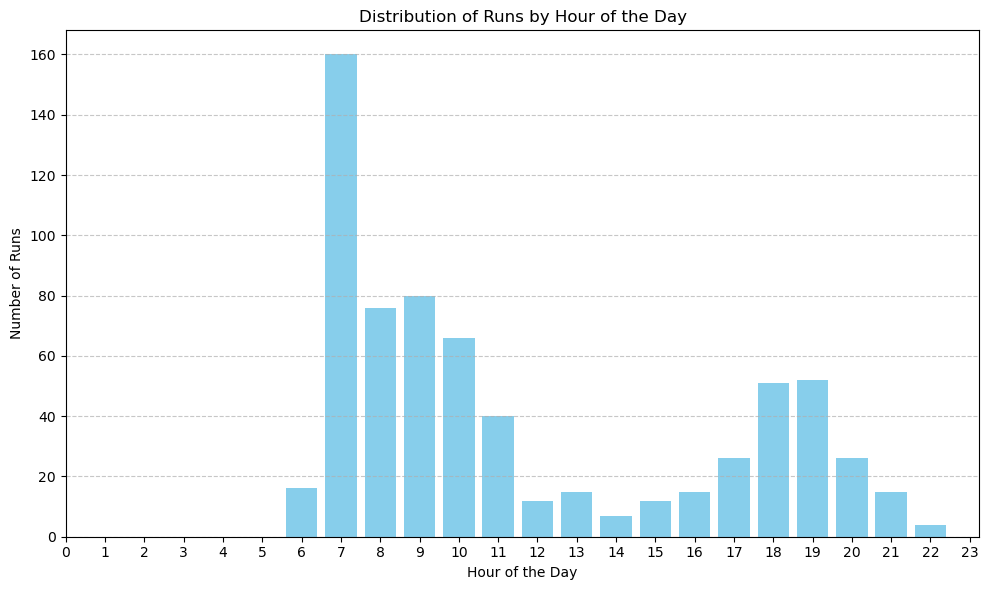

In [713]:
# extract the hour from your existing DataFrame
running_activities['Hour'] = running_activities['Date'].dt.hour

# count how many runs happened at each hour
hour_counts = running_activities['Hour'].value_counts().sort_index()

# plot
plt.figure(figsize=(10, 6))
plt.bar(hour_counts.index, hour_counts.values, color='skyblue')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Runs')
plt.title('Distribution of Runs by Hour of the Day')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [714]:
# Basic time stats
print(running_activities['Time'].describe())


count                          673
mean     0 days 00:44:32.731054977
std      0 days 00:34:49.504914134
min                0 days 00:10:26
25%                0 days 00:30:00
50%                0 days 00:36:00
75%                0 days 00:46:07
max                0 days 07:35:22
Name: Time, dtype: object


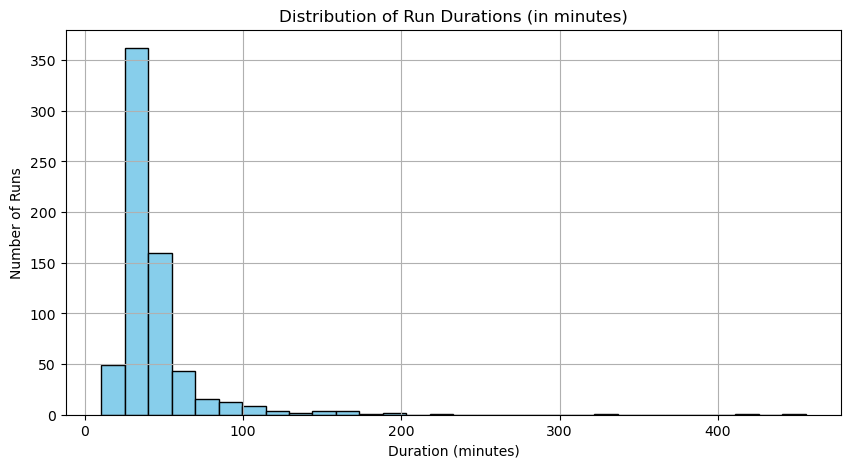

In [715]:

# Convert timedelta to minutes for visualization
durations_in_minutes = running_activities['Time'].dt.total_seconds() / 60

plt.figure(figsize=(10, 5))
plt.hist(durations_in_minutes, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Run Durations (in minutes)')
plt.xlabel('Duration (minutes)')
plt.ylabel('Number of Runs')
plt.grid(True)
plt.show()


In [716]:
# count by day
day_counts = running_activities['Day_of_Week'].value_counts().sort_index()
print(day_counts)

# most frequent day
most_common_day = day_counts.idxmax()
print(f"\nMost common day for a run: {most_common_day}")

Day_of_Week
Friday        90
Monday        79
Saturday      99
Sunday       104
Thursday     110
Tuesday      104
Wednesday     87
Name: count, dtype: int64

Most common day for a run: Thursday


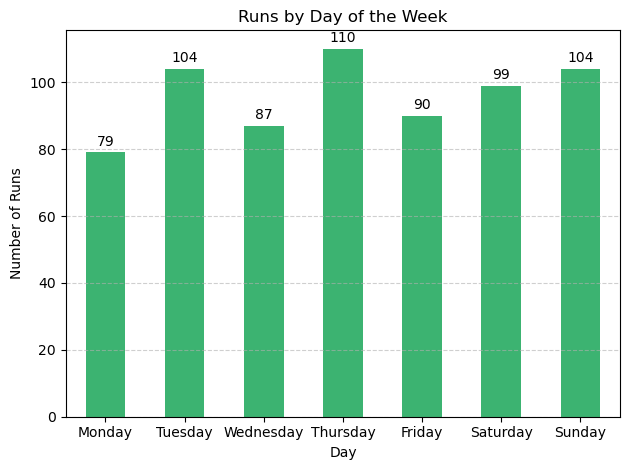

In [717]:
# Define the correct order of weekdays
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Reindex the day_counts Series to follow this order
day_counts = day_counts.reindex(ordered_days)

# Create the plot
ax = day_counts.plot(kind='bar', color='mediumseagreen')
plt.title('Runs by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Runs')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values on top of bars
for i, value in enumerate(day_counts):
    plt.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [718]:
# Only keep running and trail running activities
run_data = running_activities.copy()

# Drop any runs missing distance or time
run_data = run_data.dropna(subset=['Distance', 'Time'])

# Convert 'Time' from timedelta to minutes
run_data['Duration_Minutes'] = run_data['Time'].dt.total_seconds() / 60

# Features for clustering
X = run_data[['Distance', 'Duration_Minutes']]

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

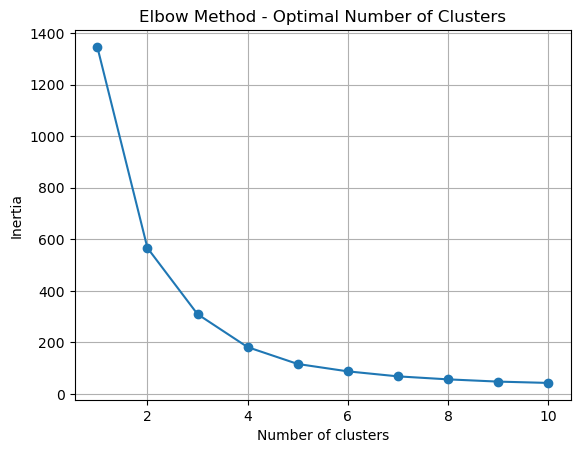

In [719]:
inertia = []

# Try 1 to 10 clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method - Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [720]:
# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
run_data['Cluster'] = kmeans.fit_predict(X_scaled)

# Add cluster centroids to the dataframe (for plotting)
centroids = kmeans.cluster_centers_

# Reverse the scaling transformation to get the real values of the centroids
centroids_real = scaler.inverse_transform(centroids)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


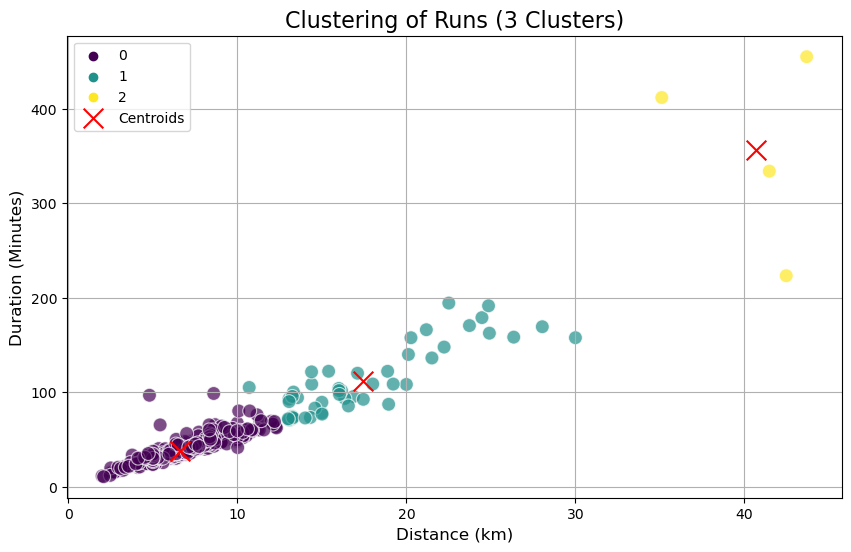

In [721]:
# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=run_data['Distance'], y=run_data['Duration_Minutes'], 
                hue=run_data['Cluster'], palette='viridis', s=100, alpha=0.7)

# Plot centroids
plt.scatter(centroids_real[:, 0], centroids_real[:, 1], 
            c='red', marker='x', s=200, label='Centroids')

# Labels and title
plt.title('Clustering of Runs (3 Clusters)', fontsize=16)
plt.xlabel('Distance (km)', fontsize=12)
plt.ylabel('Duration (Minutes)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [722]:
# Print the centroids (real scale)
print("Centroids of the clusters (Distance, Duration):")
for i, centroid in enumerate(centroids_real):
    print(f"Cluster {i+1}: Distance = {centroid[0]:.2f} km, Duration = {centroid[1]:.2f} minutes")


Centroids of the clusters (Distance, Duration):
Cluster 1: Distance = 6.58 km, Duration = 37.24 minutes
Cluster 2: Distance = 17.45 km, Duration = 111.56 minutes
Cluster 3: Distance = 40.68 km, Duration = 356.25 minutes
